# Sephora Customer Engagement Report

## Table of Links

| Description | Link |
| -- | -- |
| Reflective blog | https://ele.exeter.ac.uk/mod/oublog/view.php?id=3234123 |
| Chosen Datasets | https://www.iea.org/data-and-statistics/data-product/monthly-reliance-on-russian-oil-for-oecd-countries


## Table of Contents

1. Introduction
2. Project Context
3. Aims,Objective and Audience
4. Project Dashboard
5. Articulation of Decision Making Process
6. Review of Analytics Methods Chosen
7. Review of Available Tools
8. Review of Chosen Datasets 
9. Visualisation of Data with Accompanying Code
10. Conclusion
11. Reflective Evaluation


## Introduction

This report presents the findings from the comprehensive data analysis of customer opinions and preferences surrounding the online products of beauty company Sephora. The Kaggle dataset chosen spans from 2008 to 2023, and consists of various product attributes, including product and brand names, prices, ratings, reviews, and loves count, hence allowing exploratory analysis of factors affecting customer engagement. This allows insight into popular products, trends or brands to ultimately make strategic decisions when considering sales and marketing for growth and customer retention. 

## Project Context

The beauty industry thrives on customer engagement, where understanding product popularity can play a central role in driving customer loyalty and sales, whilst informing decisions around product and marketing strategies. 
The fourth industrial revolution demonstrates the integration of intelligent digital technologies into manufacturing and industrial processes, fundamentally changing the way we live and work (Schwab, 2016).

In this regard, transition to online sales is widespread, where many consumers prefer the convenience and comfort of online transactions, saving time and cost (Akroush & Al-Debei, 2015), resulting in online retailing driving the growth of the global beauty market by an average of 4.5% a year (Lopaciuk & Loboda, 2013).
Sephora is a worldwide leader, with over 66 million active loyal customers, shopping instore and online, therefore continuous improvement is critical to enable them to remain dominant in their field (Global Impact and Progress Report, 2023.).


## Aims, Objectives and Audiences

This project aims to provide actionable insights through an interactive dashboard that enhances Sephora’s online sales strategy by focusing on customer preferences and product popularity. The objectives are to:
1.  Visualise how the level of customer engagement varies over different product categories 
2.  Identify underperforming brands and products based on customer feedback
3.  Evaluate popular categories and those with high growth potential

The primary audience for this dashboard includes the Chief Product Officer and Chief Marketing Officer at Sephora. The dashboard will enable these executives to leverage insights to make informed decisions about where to focus efforts for maximum return. This should help Sephora prioritise promising sectors, optimise marketing strategies, and refine product selection to drive customer engagement and ultimately sales growth. 


## Project Dashboard

In [1]:

import pandas as pd
import plotly.express as px
import matplotlib  
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
import math
import dash
from dash import Dash,html, dcc, Input, Output
import dash_bootstrap_components as dbc
import dash_leaflet as d1
import dash_leaflet.express as d1x

#Reading and cleaning the data
sephora= pd.read_csv("product_info.csv")
sephora.columns=sephora.columns.str.strip()
#seeing if there are any duplicates
len(sephora['product_id'])-len(sephora['product_id'].drop_duplicates())
#seeing number of products with no number of reviews
sephora['reviews'].isnull().sum()
#fill number of reviews as 0
sephora['reviews'] = sephora['reviews'].fillna(0)
#removing products with no reviews which are new
new_0_reviews = sephora[(sephora['reviews'] == 0) & (sephora['new'] == 1)].index
sephora = sephora.drop(new_0_reviews)
#removing products with 0 reviews that are limited edition
ltd_0_reviews = sephora[(sephora['reviews'] == 0) & (sephora['limited_edition'] == 1)].index
sephora = sephora.drop(ltd_0_reviews)
#removing products with 0 reviews which are out of stock
out_0_reviews = sephora[(sephora['reviews'] == 0) & (sephora['out_of_stock'] == 1)].index
sephora = sephora.drop(out_0_reviews)
#removing final products with no values
final_0_reviews = sephora[(sephora['reviews'] == 0)].index
sephora = sephora.drop(final_0_reviews)

#Setting up graph plots
#Graph 1
first = sephora.groupby("primary_category").agg({
    'price_usd': 'mean',
    'rating': 'mean', 
    'reviews': 'sum',
    'loves_count': 'sum'}).reset_index()
fig_bar = go.Figure(
    data=[
        go.Bar(name='Average Price', x=first['primary_category'], y=first['price_usd'], yaxis='y', offsetgroup=1, marker=dict(color='blue') ),
        go.Bar(name='Reviews', x=first['primary_category'], y=first['reviews'], yaxis='y2', offsetgroup=2, marker=dict(color='purple') )
    ],
layout={
        'yaxis': {'title': 'Average Price ($)'},
        'yaxis2': {'title': 'Number of Reviews', 'overlaying': 'y', 'side': 'right'}
    }
)
fig_bar.update_layout(barmode='group', title='Average Price and Sum of Reviews per Category')
 
#Graph 2 
fig_violin=px.violin(sephora,x='primary_category', y='rating', box=True, color='primary_category', title='Distrubutions of Customer Ratings per Category')
fig_violin.update_layout(
    xaxis_title="Product Category",
    yaxis_title="Rating"
)

#Graph 3 
fig_histogram = px.histogram(sephora, x="rating", nbins=100)
fig_histogram.update_traces(marker=dict(line=dict(width=1, color='black')))
fig_histogram.update_layout(
    title="Distribution of Ratings",  
    xaxis_title="Rating",         
    yaxis_title="Count"             
) 

#Graph 4
brand = sephora.groupby(["brand_name"]).agg(
   reviews_sum=('reviews', 'sum'),
   rating_mean=('rating', 'mean'),
   loves_sum=('loves_count', 'sum')
).reset_index()
brand_sorted = brand.sort_values(by='rating_mean')
lowest_brand = brand_sorted.iloc[: -int(brand_sorted.shape[0] * 0.95), :]
fig_pairplot = px.scatter_matrix(
    lowest_brand,  # DataFrame containing your data
    dimensions=["reviews_sum", "rating_mean", "loves_sum"],  
    color="brand_name",  # Color points by the brand name
    color_discrete_sequence=px.colors.qualitative.Light24,
    title="Pairplot of the 5% of Brands with Lowest Ratings", 
    labels={  
        "reviews_sum": "Total Reviews",
        "rating_mean": "Average Rating",
        "loves_sum": "Total Loves"
    },
)
plt.close()

#Graph 5
sephora_customer=sephora[['product_id', 'primary_category', 'reviews', 'rating', 'loves_count']]
sephora_customer_copy = sephora_customer.copy()
hover_text = []
bubble_size = []
for index, row in sephora_customer_copy.iterrows():
    hover_text.append(('Product: {product_name}<br>'+
                      'Rating: {rating}<br>'+
                      'Number of reviews: {reviews}<br>'+
                      'Number of loves: {loves_count}<br>'+
                      'Category: {primary_category}<br>'
                      ))
    bubble_size.append(math.sqrt(row['loves_count']))
sephora_customer_copy['text'] = hover_text
sephora_customer_copy['size'] = bubble_size
sizeref = 2.*max(sephora_customer_copy['size'])/(30**2)
category_names = ['Fragrance', 'Bath & Body','Mini Size','Hair', 'Makeup','Skincare','Tools & Brushes','Men','Gifts']
category_data = {category:sephora_customer_copy.query("primary_category == '%s'" % category)
                              for category in category_names}
fig_bubble = go.Figure()
for category_name, category in category_data.items():
    fig_bubble.add_trace(go.Scatter(
        x=category['rating'], y=category['reviews'],
        name=category_name, text=category['text'],
        marker_size=category['size'],
        ))
fig_bubble.update_traces(mode='markers', marker=dict(sizemode='area',
                                              sizeref=sizeref, line_width=2))
fig_bubble.update_layout(
    title=dict(text='Sephora Product Engagement Analysis'),
    xaxis=dict(
        title=dict(text='Rating'),
        gridcolor='white',
        type='log',
        gridwidth=2,
    ),
    yaxis=dict(
        title=dict(text='Sum of Reviews'),
        gridcolor='white',
        gridwidth=2,
    ),
    plot_bgcolor='rgb(243, 243, 243)',   
)
plt.close()

#Graph 6 
seph_sm = sephora[sephora['primary_category'].isin(['Makeup', 'Skincare'])]
sm_data=seph_sm.groupby(["primary_category", "secondary_category"])[["reviews"]].sum().reset_index()
fig_stacked = px.bar(sm_data, x="primary_category", y="reviews", color="secondary_category", title= "Sum of Reviews of Sub-categories Within Makeup and Skincare",
            hover_data=['reviews'], barmode = 'stack')
fig_stacked.for_each_trace(lambda trace: trace.update(name=trace.name.replace('secondary_category', 'Product Sub-category')))
fig_stacked.update_layout(
    xaxis_title="Product Category",  
    yaxis_title="Sum of Reviews",  
)

#Set up dash app and colour theme
# Create Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
# Set colors to be used in dashboard
colors = {'background': '#5064ad', 'text': 'white'}
# Layout of dashboard
app.layout = dbc.Container([ #Whole Dashboard
    # Dashboard title
    html.H1(
        'Sephora Customer Engagement Dashboard',
        style={
            'color': colors['text'],
            'backgroundColor': colors['background'],
            'textAlign': 'center',
            'border': '2px black solid',
            'marginTop': '5px',
            'marginBottom': '5px'        
             }
            ),
#Dashboard graphs (3 rows of 2) 
dbc.Row([ #Row 1 of 3
    dbc.Col([
        dcc.Graph( #Graph 1
                id='Bar',
                figure=fig_bar,
                style={'marginTop': '0px'}  
                )
            ], width=6 ,style={'padding': '0', 'display': 'flex', 'justifyContent': 'center', 'alignItems': 'center'}),#Column styling and end column
    dbc.Col([ #Graph 2
             dcc.Graph( 
                id='Violin',
                figure=fig_violin,
                style={'marginTop': '0px'}  
                )
            ], width=6 ,style={'padding': '0', 'display': 'flex', 'justifyContent': 'center', 'alignItems': 'center'}),#Column styling and end column
        ]),#end of row
dbc.Row([ #Row 2 of 3
    dbc.Col([
        dcc.Graph( #Graph 3
                id='Histogram',
                figure=fig_histogram,
                style={'marginTop': '0px'}  
                )
            ], width=6 ,style={'padding': '0', 'display': 'flex', 'justifyContent': 'center', 'alignItems': 'center'}),#Column styling and end column  
    dbc.Col([ #Graph 4
            dcc.Graph( 
                id='Pairplot',
                figure=fig_pairplot,
                style={'marginTop': '0px'}  
                )
            ], width=6 ,style={'padding': '0', 'display': 'flex', 'justifyContent': 'center', 'alignItems': 'center'}),#Column styling and end column
        ]),#end of row
dbc.Row([ #Row 3 of 3
    dbc.Col([
        dcc.Graph( #Graph 5
                id='Bubble',
                figure=fig_bubble,
                style={'marginTop': '0px'}  
                )
            ], width=6 ,style={'padding': '0', 'display': 'flex', 'justifyContent': 'center', 'alignItems': 'center'}),#Column styling and end column    
    dbc.Col([ #Graph 6
            dcc.Graph( #Graph 5
                id='Stacked',
                figure=fig_stacked,
                style={'marginTop': '0px'}  
                )     
            ], width=6 ,style={'padding': '0', 'display': 'flex', 'justifyContent': 'center', 'alignItems': 'center'})#Column styling#Column styling
            , #end of column
        ]),#end of row
#end of container and its style
                        ], fluid=True,
                            style={ 'width': '100%',
                                    'display': 'inline-block',
                                    'padding': '0' }  
                        )
# Run the app
if __name__ == '__main__': 
     app.run_server(debug=True) 

 

## Articulation of Decision Making Process

### Data cleaning
Ahead of dashboard creation, it was vital to ensure the dataset was prepared for comprehensive analysis through cleaning. As referenced in the week 9 blog post, columns with large proportions of missing values were dropped from the dataset. Of the columns used in the analysis, only the rate and reviews columns had empty values which needed to be addressed. The data was filtered to identify rows with no reviews, and where these rows represented products which were new, out of stock or limited edition, these were also dropped, as these factors were thought to explain the lack of reviews. As there were only 103 remaining products with no reviews, encompassing only 1.2% of the total products, these were also dropped from the data.

### Stages of design

Some stages of design were illustrated in the reflective blog, as the week 7 blog post mentions the initial use of excel work, through creation of pivot tables, followed by descriptive analysis using bar charts and plots of distribution. This was used to gain a big picture scope of the data, to consider potential areas for greater analysis. 
More in depth analysis then occurred, where scatter plots were used to understand the correlation between variables, such as reviews and rating, alongside clustering through use of hue to identify grouped data reflecting potential success in a particular category. Following this, visualisation of subcategory contributors enabled more insight into the significance of subcategories.
A monitor, analyse, drill down approach was used when considering dashboard design (Eckerson, 2006), as the aforementioned broader work was utilised first, through both the bar chart and also the data displaying distributions. Further analysis was then displayed using various scatterplots to identify relationships and correlation within the data, before finally culminating in the more in depth subcategory work. This methodology provides the means for executives to create insightful strategies based on the varying levels of analysis. Alongside this, the interactive nature of the dashboard allows the user to hover over many of the graphs to learn exact numbers of the plotted data, increasing clarity of visualisations, as well as zooming in for greater detail



### Key principles

With the aim being to demonstrate ranging customer opinions across the products sold online at Sephora, it was important to display this in a concise and digestible way. In this regard, important principles of visualisation theory were considered during chart choice and creation, and ultimately dictated decisions surrounding dashboard layout. Some key principles and how they are implemented are discussed.

#### Visualisations

The purpose and nature of the visualisation should be considered when choosing the type for each graph. The visualisations are vastly declarative and data-driven, hence are a form of “everyday dataviz” to be presented to executives for them to make decisions based on this visualisation (Berinato, 2016).
The relationship between the data was considered, for instance the part to whole relationship for the skincare and makeup subsectors suggests a stacked bar chart (Few, 2012), whereas understanding the correlation between continuous data is better suited to a bubble plot.
Within each chart, it’s important to reduce the cognitive load for the user through increasing the data ink ratio (Tufte, 2001). Unnecessary chartjunk was therefore removed from the visualisations, through the removal of excessive zeros on the axes and the use of hover components rather than stationary labels


#### Dashboard layout

The dashboard involved 6 visualisations, so as to not overwhelm the executives, as although progression from George Miller’s “the magic number 7 plus or minus 2” is now that the working memory can only hold around 4 chunks of information, if fewer graphs were used this would prove too little data for executives to make data-driven decisions (Miller, 1956),(Cowan, 2001). 
The use of a dashboard affords exploration by the use, where hovering over the charts and use of dropdowns provides feedback (Norman, 2013). 
Also, when considering dashboard design, is it preferable for this to be aesthetically pleasing to the user, as this can be seen to improve experience of use, through to the aesthetic usability effect (Yablonski, 2018). Therefore, the colour scheme was consistent where possible and used of clear titles and labels ensured optimal experience for the executives when exploring the dashboard.


## Review of Analytics Methods Chosen

When visualising the data, a variety of methods were used to complement each other to create an impactful overall dashboard. The analysis initially provided a broad overview, before allowing understanding about relationships within the data and giving more detailed insight in previously identified sectors, for more tailored areas to target. 

Descriptive statistics were used initially, to calculate the sum, mean or standard deviation of various categories to be able to make comparisons in terms of central tendency and spread.

The use of dual axes on the bar chart allowed both average price and sum of reviews to compared simultaneously by sector. Although a horizontal bar graph is sometimes clearer to read due to the ease of reading axis label, as there were 2 axes, a horizontal plot would be unintuitive for the user.  It is important to fit visualisations to users’ mental models (Florian Windhager & Mayr, 2023), for user-oriented design, hence a vertical plot used.

Distribution of data was visible using a violin plot and a histogram, to obtain a high level view of the overall spread of the data to see if the general opinion of Sephora was positive and if products were highly rated. When choosing the number of bins for the histogram, the minimum 
amount was used to portray the data. 

Further exploratory data analysis through scatter and bubble plots simultaneously looked at clustering and correlation of the data to identify relationships within the data. Also, this analysis enables the identification of outliers, and whether they originate more from certain categories or brands to attempt to understand the reasons behind them. Findings from these were then used for further analysis, for instance through the stacked bar chart to visualise the relative size of each sub-category within identified group for more specific areas to target.



## Review of Available Tools

A variety of python libraries were used, however, the most effective one used for the dashboard was Plotly, as this allowed interaction through hovering over data to pick out certain products or brands. This was useful as there were a large number of data points for some, so Plotly allowed greater usability. The dashboard was created using dash, which allowed for effective visualisation and layout of the graphs, however other tools could have been used to enhance the dashboard capabilities.

### Alternatives

The use of Panel, a library built on top of the Bokeh library, could be a good alternative, as this allows creation of a dashboard with interactive components which works well with a variety of plotting libraries, such as matplotlib, so may be beneficial over Dash to create a more customised dashboard (Matplotlib — Panel V1.5.4, 2024).

Since the dashboard is used in a business environment, Tableau could be considered, as this can help enrich analytics data with business context and meaning, and be integrated alongside other business tools (Tableau, 2024).

### Barriers

The use of python and understanding of how to manipulate and visualise data had a steep learning curve. Initially, all graphs were created in matplotlib and Seaborn as these were more beginner-friendly, however it was only apparent when creating the dashboard that these libraries were not compatible with dash. Therefore, decisions were made about whether to recreate graphs in Plotly or include images, as when converting original graphs to Plotly this often disturbed the layout. For example when producing the pairplot in Plotly, the histogram was lost on the diagonal, likely due to the difficulty of relatively few data points. The Plotly version was displayed in the dashboard, with the Seaborn version in the visualisation section to display other options.

Although the use of Panel would mean this is less of an issue, this involved use of a whole new library, hence would require an effort to understand and master layout configurations. Similarly, although tableau is seen as user-friendly, there is still a need for technical knowledge surrounding this software.

Initially, the intention was for a dropdown to be used in the dashboard for the first graph in order to be able to switch between looking at each primary category in terms of reviews, loves and price, however, this involved complex callback function and was considered beyond the scope of this project, as to implement this feature was potentially extremely time consuming. As an alternative, twin axes to observe reviews and price simultaneously were used, as this was almost as effective, and allowed time to ensure the clarity and quality of other components within the dashboard. 



## Review of Chosen Datasets

My dataset was sourced from Kaggle, spanning from 2008 to 2023, with information about over 8000 beauty products at the Sephora online store. There was a plethora of relevant information surrounding customer opinions, split by product, brand and various levels of category, so the data could be easily clustered based on these to identify trends. There were many products and brands, useful for broad analysis of factors behind customer preference. This meant it was more difficult to visualise products individually, however this was combatted through first visualising by category, followed by more specific analysis based on subcategories or success level for individual products. 

There were many missing values in the dataset across almost all categories, making some ineffective for analysis, hence four columns were dropped. However, for the relevant categories to make meaningful conclusions, only the rate and reviews columns have empty values, so suitable decisions were made surrounding how to deal with these null values. It was mentioned in the week 9 blog post that products with no reviews which were new, out-of-stock or limited edition were dropped, as these factors may have skewed the data, hence it is sensible to remove them from the data rather than being unfairly scrutinised for lack of popularity.


## Visualisations with Accompanying Code

In the dashboard, some graphs are used for descriptive visualisation, and other used for more actionable insight. 3 key visualisations have been chosen to discuss in more detail below.

The histogram was key to display the distribution of product ratings across Sephora. They predominantly fall within the range of 3.5 to 5, however, there are several products with very low ratings which could potentially be removed to allow greater emphasis of successful existing products and the introduction of trending products. The data is assumed to roughly follow a normal distribution, although shifted slightly, hence 99.7% of the data will fall withing 3 standard deviations of the mean (Anderson, 2020). This is suggested as a suitable threshold for product removal, meaning products below a rating of 2.6 would be considered for removal from Sephora’s product line by executives, when looked at in conjunction with other factors, such as sales performance. Although there may be outliers, it is unlikely that a product with such a low average rating would be popular, with a large customer base however, the number of reviews can be checked before removal, and evaluate each on a case-by-case basis. 

Brands were sorted based on rating and the bottom 5% were visualised using a pairplot. This was used to evaluate these brands based on rating, reviews and number of loves to consider all factors of customer opinions at once. This reduces the potential that a low rated brand could have a very popular standout product which would be rashly removed, hence brands which were low for all 3 could also be considered for removal from Sephora, alongside other relevant factors. The scatterplot nature of each square allows pre-attentive processing of standout brands. For example, the brand Floral Street has substantially more reviews, and Slip has substantially more loves, so these may not be sensible brands to remove, as they may have a standout product which is a customer favorite or are just a successful brand despite the low rating. On the other hand, the brand 19-69 s consistently near the bottom left of the graphs, hence has great potential to be dropped by Sephora.

The stacked bar chart was created based on the insight gained from the previous bubble plot, demonstrating that makeup is the most successful sector, and skincare is a potential growth category which is increasing in popularity. Hence the subcategories are investigated, to determine each’s contribution to the overall sector through its part-to-whole relationship. Face and eye are the largest categories in makeup, both staples of an everyday makeup routine, so when considering new strategies, it’s important that Sephora doesn’t neglect the basics. Many products within these categories are staples that customers will repurchase for many years, so Sephora want to decrease customer churn rate by ensuring these products remain available and attractive. The case is similar with skincare, as cleansers and moisturisers are prominent, and both used in an everyday skincare routine, so Sephora should ensure these are well stocked on their website to ensure customer loyalty. However, there is also a large contribution from treatments, which is more of a broad category where customers tend to experiment more, hence Sephora want to ensure they are considering new product releases, as product formula is constantly improving, and novel ingredients can often be trending areas. Furthermore, the first graph demonstrated that skincare is a high value category, which was identified early on in investigation as mentioned in the week 8 blog post. Within this, treatments can often come at a high price point, hence this is an ideal category to exploit, in terms of product selection and marketing of these products.



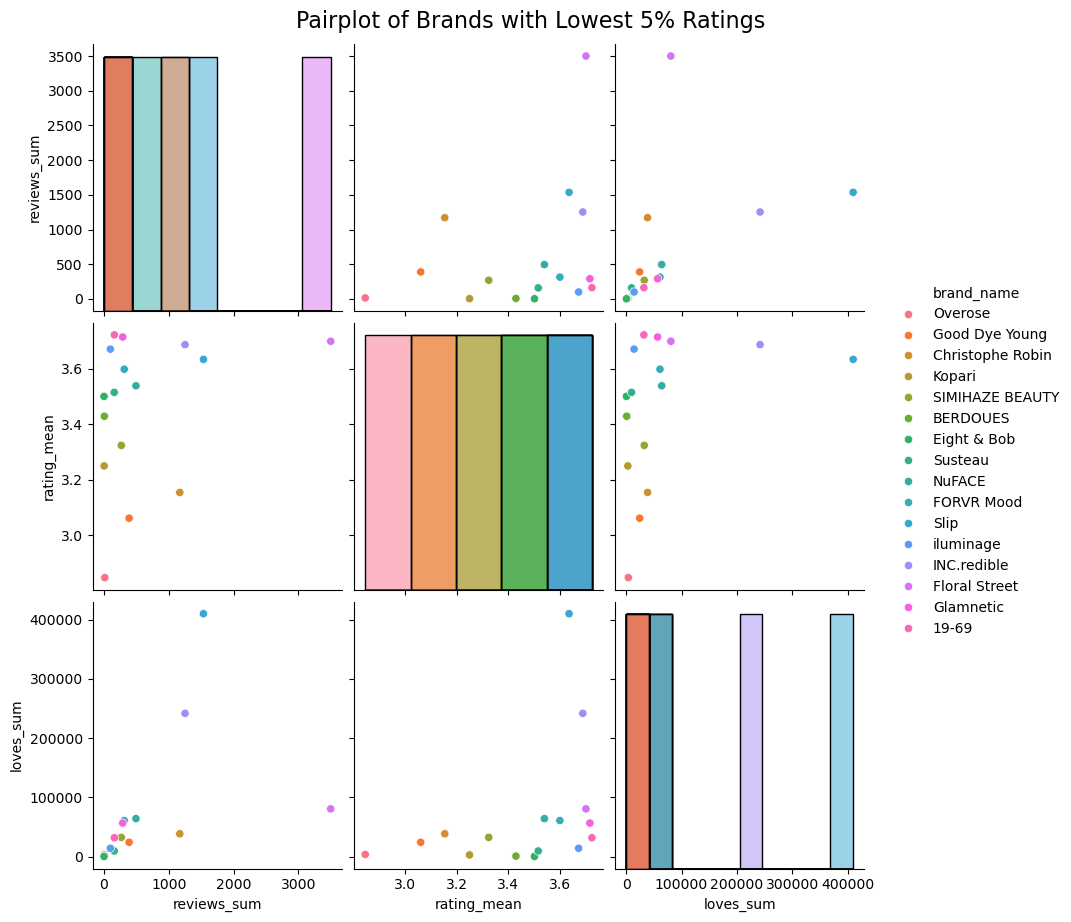

In [2]:
#histogram
fig_histogram = px.histogram(sephora, x="rating", nbins=100)
fig_histogram.update_traces(marker=dict(line=dict(width=1, color='black')))
fig_histogram.update_layout(
    title="Distribution of Ratings",  # Title of the plot
    xaxis_title="Rating",            # Label for the x-axis
    yaxis_title="Count"              # Label for the y-axis
)
fig_histogram.show()

#pairplot
brand = sephora.groupby(["brand_name"]).agg(
    reviews_sum=('reviews', 'sum'),
    rating_mean=('rating', 'mean'),
    loves_sum=('loves_count', 'sum')
).reset_index()
brand_sorted = brand.sort_values(by='rating_mean')
lowest_brand = brand_sorted.iloc[: -int(brand_sorted.shape[0] * 0.95), :] 

pair_seph=sns.pairplot(data=lowest_brand, hue="brand_name", diag_kind="hist", height=3)
plt.suptitle("Pairplot of Brands with Lowest 5% Ratings", fontsize=16, y=1.02)
plt.show()

#stacked bar chart
seph_sm = sephora[sephora['primary_category'].isin(['Makeup', 'Skincare'])]
sm_data=seph_sm.groupby(["primary_category", "secondary_category"])[["loves_count","reviews"]].sum().reset_index()
# Create the stacked bar plot
fig_stacked = px.bar(sm_data, x="primary_category", y="reviews", color="secondary_category",
                     hover_data=['reviews'], barmode='stack')
fig_stacked.update_layout(
    title="Total Reviews by Primary and Secondary Category",  
    xaxis_title="Primary Category",  
    yaxis_title="Total Reviews"     
)
fig_stacked.show()


## Conclusion

Creation of the dashboard successfully achieves its desired aim, through the investigation of the outlined objectives. Data presentation to the executives through the means of an interactive dashboard effectively portrays how customer engagement varies across product category, identifying underperforming brands and products, and highlighting popular and potential growth categories. The dashboard demonstrated that skincare has potential, and within this, skincare treatments could be an area to target, as it is a high value sub-category with growing popularity. Therefore, it is crucial that Sephora consider strategies to enhance this area, perhaps considering which complementary products could be added to propel this further.

The dashboard successfully conveys the necessary data in a concise and manageable manner, allowing key takeaways to be clearly visible, alongside further insight through greater utilisation of the dashboard. The executives can utilise the insights gleaned from the dashboard, alongside other readily available data, such as sales data to make strategic decisions in terms of products, brands and marketing strategies to ultimately maximise sales growth. This will enable Sephora to remain a global success in the beauty industry and retain their extensive customer base.


## Reflective Evaluation

When reflecting on the project as a whole, several areas are prominent.

The use of python and its various libraries for data analysis had a steep learning curve, where initial efforts moved at a slower pace whilst gaining understanding of the tools and potential methods of implementation. If repeating the project, the data analysis process would be greatly sped up, allowing the creation of more complex visualisations, however it is important that the key objectives are not obscured through the use of inappropriate, overly complex methods.

During the project, the number of reviews was used as a relative estimate for sales and the overall popularity, therefore success of products was understood using a combination of this with rating and number of loves, however a time series element to the data would have brought meaningful insights to demonstrate how these customer opinions changed over time. This would portray the growing increase or decline of different products or sectors and allow for trends to be spotted, with modelling then used to forecast the trajectory of these in the future. 

This demonstrates the importance of dataset selection, although the information learnt is still extremely beneficial to Sephora’s executives and would be enhanced through use of additional data. 
Overall, the best use of this data would be in conjunction with time-series sales data 



## References

Akroush, M. N., & Al-Debei, M. M. (2015). An integrated model of factors affecting consumer attitudes towards online shopping. Business Process Management Journal, 21(6), 1353–1376. https://doi.org/10.1108/bpmj-02-2015-0022

Anderson, D. R. (2020). Statistics for business & economics. Cengage Learning.

Berinato, S. (2016, June). Visualisations That Really Work. Harvard Business Review. https://hbr.org/2016/06/visualisations-that-really-work

Cowan, N. (2001). The Magical Number 4 in short-term memory: a Reconsideration of Mental Storage Capacity. Behavioral and Brain Sciences, 24(1), 87–114. https://doi.org/10.1017/s0140525x01003922

Eckerson, W. (2006). Deploying Dashboards and Scorecards TDWI BEST PRACTICES REPORT. http://download.101com.com/pub/tdwi/Files/RRS_DB_Q206_F_web.pdf

Few, S. (2012). Show me the numbers : designing tables and graphs to enlighten. Analytic Press.

Florian Windhager, & Mayr, E. (2023). Mental Models and Visualisation. Springer EBooks, 65–83. https://doi.org/10.1007/978-3-031-34738-2_3

INSPIRE MEANINGFUL BEAUTY 2023 Global Impact and Progress Report. (n.d.). Retrieved December 16, 2024, from https://www.inside-sephora.com/sites/default/files/2024-09/SEPHORA_2023%20Global%20Impact%20%26%20Progress%20Report_17092024%20FINAL.pdf

Łopaciuk, A., & Łoboda, M. (2013). GLOBAL BEAUTY INDUSTRY TRENDS IN THE 21st CENTURY. https://toknowpress.net/ISBN/978-961-6914-02-4/papers/ML13-365.pdf

Matplotlib — Panel v1.5.4. (2024). Holoviz.org. https://panel.holoviz.org/reference/panes/Matplotlib.html

Miller, G. A. (1956). The magical number seven, plus or minus two: Some limits on our capacity for processing information. Psychological Review, 63(2), 81–97. https://doi.org/10.1037/h0043158

Norman, D. (2013). The Design of Everyday Things. MIT Press. (Original work published 1988)

Tableau. (2024). Tableau. https://www.tableau.com/en-gb/products/tableau?d=7013y0000020Sg7AAE&nc=7013y0000020Z1zAAE&utm_content=7013y0000020Sg7AAE&utm_source=google&utm_medium=paid_search&utm_campaign=21475219080&utm_adgroup=164569567629&utm_term=products%20of%20tableau&utm_matchtype=p&gad_source=1&gclid=CjwKCAiA34S7BhAtEiwACZzv4YJHW94AG1f-r3qp0D3y4qDPC5H5sfxKOXJqdv-NCEimbOHgLDrxOBoCCA0QAvD_BwE&gclsrc=aw.ds

The Fourth Industrial Revolution. (2016). Google Books. https://books.google.co.uk/books?hl=en&lr=&id=ST_FDAAAQBAJ&oi=fnd&pg=PR7&dq=(The+Fourth+Industrial+Revolution,+by+Klaus+Schwab,+2016&ots=DViy8QwCXP&sig=L8iyzC9_3_x2_QUy3fWevlrwYQ0&redir_esc=y#v=onepage&q=(The%20Fourth%20Industrial%20Revolution%2C%20by%20Klaus%20Schwab%2C%202016&f=false

Tufte, E. R. (2001). The visual display of quantitative information (2nd ed.). Graphics Press.

Yablonski, J. (2018). Laws of UX. Laws of Ux. https://lawsofux.com/

